In [1]:
import cobra 
import matplotlib.pyplot as plt
import pandas as pd

# Flux distribution analysis

First load the model which grows on SNM3 media. Note than in previous notebook the default media was set to be SNM3 so we only have to load it.

In [2]:
model = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print(model.slim_optimize())

2.558694612613393


In [3]:
snm3 = pd.read_csv("SNM3.csv", sep=";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


We now will compute all fluxes through FBA, together with their bounds using FVA. This is done for all reactions.

In [4]:
# Computing all fluxes
sol = model.optimize()

In [5]:
# Flux variability analyisis for all
fva = cobra.flux_analysis.flux_variability_analysis(model)

In [6]:
# Sticking them together
df_fluxes = fva.copy()
df_fluxes["flux"] = sol.fluxes
df_fluxes.to_excel("fluxes_SA.xlsx")
df_fluxes

,minimum,maximum,flux
10M3HDHL,0.007757,7.756924e-03,0.007757
10M3OACPO,0.148011,1.480111e-01,0.148011
10M3OUO,0.007757,7.756924e-03,0.007757
10MDOD,0.148011,1.480111e-01,0.148011
10MTDAO,0.148011,1.480111e-01,0.148011
...,...,...,...
GLYCLTt,-0.001141,-1.141178e-03,-0.001141
r2535,0.000000,0.000000e+00,0.000000
UAG2EMA,0.000000,0.000000e+00,0.000000
GLUt3,0.000000,-3.943512e-13,0.000000


Here we plot all non-zero fluxes which are around 256. They are mostly rather small with some outliears. The x-axis contains labels from fluxes which were rather high/low.

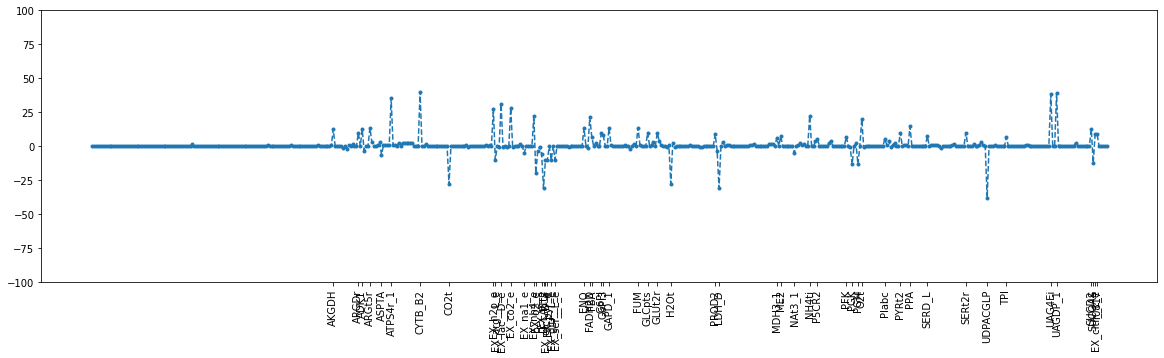

In [7]:
plt.figure(figsize=(20,5))
non_zero_flux = df_fluxes["flux"].loc[df_fluxes["flux"] != 0]
plt.plot(non_zero_flux.index, non_zero_flux, ".--")
plt.ylim(-100,100)
high_vals = df_fluxes.index[df_fluxes["flux"] > 5].tolist() + df_fluxes.index[df_fluxes["flux"] < -5].tolist()
a = plt.xticks(high_vals, rotation=90)

## Plotting exchange fluxes

We will plot the bounds for the exchange fluxes such that the organism still achives maximal growth. This is done with FVA, we recompute them here for convecnience but can also be extracted from previous list.

In [8]:
# Exchange fluxes fva, for all non-zero exchanges
fva_ex = model.summary(fva=1.)
fva_ex = fva_ex.to_frame()

In [9]:
# Get necessary values for plotting
x = []
y_fluxes = []
y_min_flux = []
y_max_flux = []
for _, data in fva_ex.iterrows():
    # Get the data
    id = str(data.metabolite[:-2])
    f = data.factor*data.flux 
    f_min = data.factor*data.minimum
    f_max = data.factor*data.maximum
    # Save it if its contained in snm3 and is nonzero
    if not (f_min == 0 and f_max == 0):
        for j in range(len(snm3)):
            ide = str(snm3.iloc[j][1]) + "_e"
            if ide == id + "_e":
                x.append(str(snm3.iloc[j][0]))
                y_fluxes.append(f)
                y_min_flux.append(f_min)
                y_max_flux.append(f_max)




In [10]:
len(x)

30

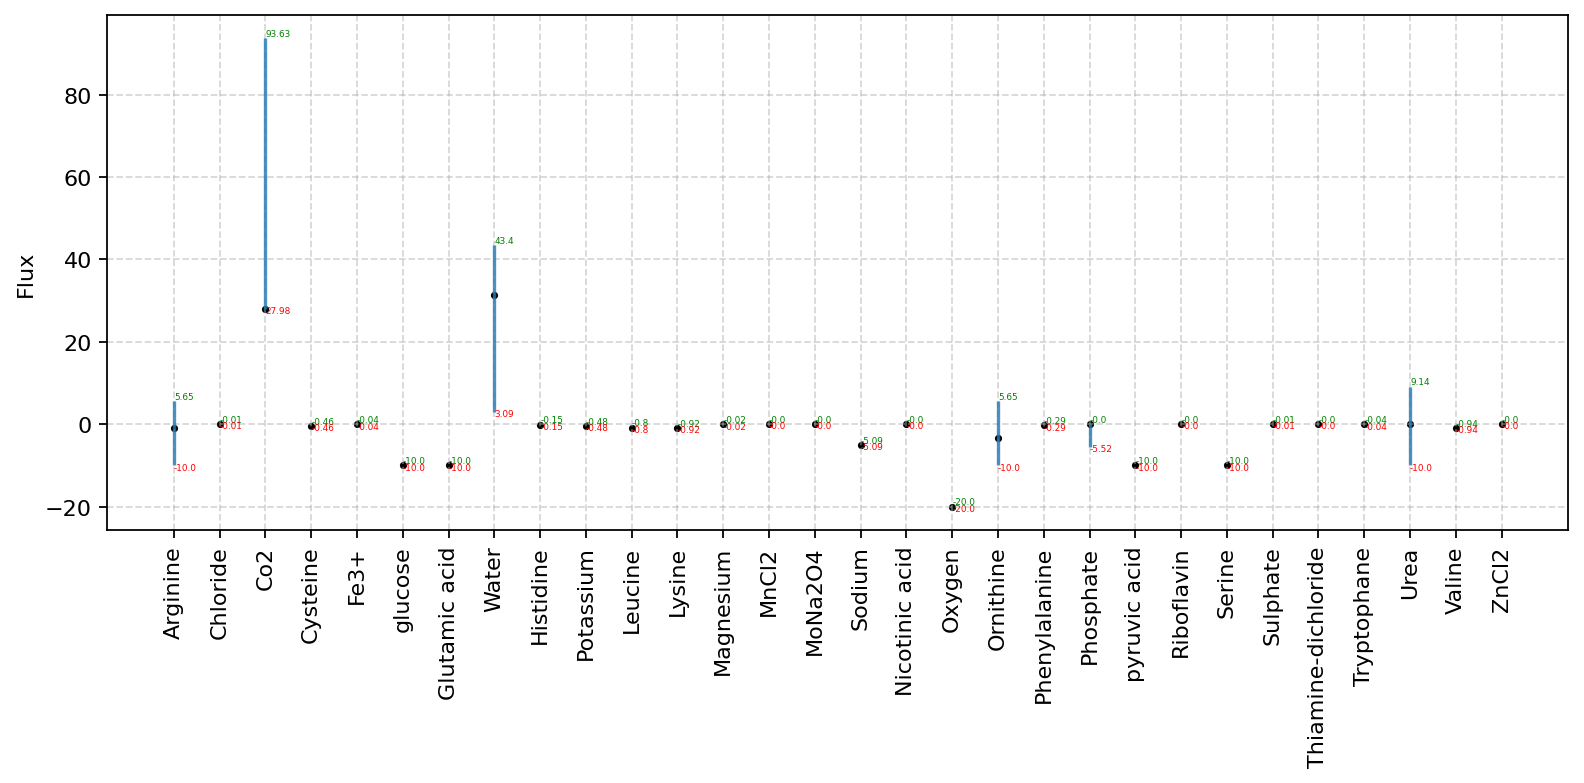

In [13]:
# Draw plot
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 
fig = plt.figure(figsize=(10,5), dpi= 160)
plt.vlines(x=x, ymin=y_min_flux, ymax=y_max_flux, alpha=0.8, color="C0")

# Plot FBA flux value as black dot
plt.scatter(x=x, y= y_fluxes, color="black",s=5)

#Plot maximum/minimum value in green
for y_min, x1, y_max in zip(y_min_flux, x, y_max_flux):
    t = plt.text(x1,y_min+0.1, round(y_min, 2), horizontalalignment='left', color="green",
                verticalalignment='bottom', size=4)
    t = plt.text(x1,y_max-1.5, round(y_max, 2), horizontalalignment='left', color="red",
                verticalalignment='bottom', size=4)

# Decorations    
#plt.title('Exchange flux range',  **title_font)
plt.xticks(x,rotation=90)
plt.grid(linestyle='--', alpha=0.5)
plt.ylabel("Flux")
fig.tight_layout()
plt.show()
fig.savefig("ex_flux_SA_RM.pdf")